# Access GLCFS model output from THREDDS Server with Python

This notebook is help users get started using FVCOM output from the [GLERL THREDDS Server](https://www.glerl.noaa.gov/thredds/catalog/catalog.html). This example includes data from the Great Lakes Coastal Forecasting System ([GLCFS](https://www.glerl.noaa.gov/res/glcfs/)). Learn more about [GLCFS here](https://www.glerl.noaa.gov/res/Programs/ipemf/GLCFS_nextgen.html) and how to access both experimental and operational data on the [Data Access page here](https://www.glerl.noaa.gov/res/Programs/ipemf/glcfs_data_access.html).

The Python modules used in this example are fairly common. Advanced users may be interested in using the module [PyFVCOM](https://github.com/pmlmodelling/pyfvcom).  More examples of PyFVCOM can be found [here](https://notebook.community/pwcazenave/PyFVCOM/examples/pyfvcom_plot_example).

Thank you those whose code we based this notebook from including Rich Signell USGS [avavilable here](https://nbviewer.org/github/rsignell-usgs/ipython-notebooks/blob/master/files/FVCOM_depth_and_velocity.ipynb) and Tristan Salles [available here](https://tristansalles.github.io/Coast/queryocean/oceanforecast.html).

In [2]:
import time

%matplotlib inline
# from pylab import *
import numpy as np
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
import netCDF4
import datetime as dt
import pandas as pd
from io import StringIO

import pyproj


%config InlineBackend.figure_format = 'png'
plt.rcParams['mathtext.fontset'] = 'cm'

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Time to sleep in seconds before each opendap call to give server time to respond 
opendap_pause = 1 

## Loading the FVCOM file


In [4]:
# Set the URL
url = 'https://www.glerl.noaa.gov/thredds/dodsC/glcfs/erie/nowcast/052200_0001.nc'

# Load it via OPeNDAP
nc = netCDF4.Dataset(url)

# Query the variables
time.sleep(opendap_pause)
for var in nc.variables.keys() :
    print(var)

nprocs
partition
x
y
lon
lat
xc
yc
lonc
latc
siglay
siglev
siglay_center
siglev_center
h_center
h
nv
iint
time
Itime
Itime2
Times
zeta
nbe
ntsn
nbsn
ntve
nbve
a1u
a2u
aw0
awx
awy
art2
art1
u
v
tauc
omega
ww
ua
va
temp
salinity
viscofm
viscofh
km
kh
kq
q2
q2l
l
short_wave
net_heat_flux
sensible_heat_flux
latent_heat_flux
long_wave
uwind_speed
vwind_speed
wet_nodes
wet_cells
wet_nodes_prev_int
wet_cells_prev_int
wet_cells_prev_ext
aice
vice
tsfc
uuice
vvice


In [5]:
# take a look at the "metadata" for the variable "u".
time.sleep(opendap_pause)
print (nc.variables['u'])

<class 'netCDF4._netCDF4.Variable'>
float32 u(time, siglay, nele)
    long_name: Eastward Water Velocity
    standard_name: eastward_sea_water_velocity
    units: meters s-1
    grid: fvcom_grid
    type: data
    coordinates: time siglay latc lonc
    mesh: fvcom_mesh
    location: face
unlimited dimensions: time
current shape = (12, 20, 11509)
filling off


## Set FVCOM simulation time

In [6]:
# Enter your specific date & time in UTC
# This must be contained in the file you selected in the 'URL'
# variable above
time_extract = dt.datetime(2023,5,21,0,0,0) # year,month,day,hour,minute,second

# Get desired time step 
time.sleep(opendap_pause)
time_var1 = nc.variables['Itime']
time_vals = netCDF4.num2date(time_var1, time_var1.units) + nc.variables['Itime2'][:] * dt.timedelta(milliseconds=1)

# Get desired time step
itime = np.argmin(np.abs(time_vals-time_extract))
print(itime, time_extract)

11 2023-04-25 12:00:00


In [7]:
# Print extracted time
dtime = time_vals[itime]
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(daystr)

2023-Apr-25 12:00


## Get specific data from FVCOM outputs

In [8]:
# Get lon,lat coordinates for nodes (depth)
time.sleep(opendap_pause)
lat = nc.variables['lat'][:]

time.sleep(opendap_pause)
lon = nc.variables['lon'][:]

In [9]:
# Get lon,lat coordinates for cell centers (depth)
time.sleep(opendap_pause)
latc = nc.variables['latc'][:]

time.sleep(opendap_pause)
lonc = nc.variables['lonc'][:]

In [10]:
# Get depth
time.sleep(opendap_pause)
h = nc.variables['h'][:]

In [12]:
# Get Connectivity array
time.sleep(opendap_pause)
nv = nc.variables['nv'][:].T - 1 

In [13]:
# Take FVCOM Delaunay grid
time.sleep(opendap_pause)
tri = Tri.Triangulation(lon,lat,triangles=nv)

## Find FVCOM velocity field

In [14]:
# Get current at layer [0 = surface, -1 = bottom]
ilayer = 0

time.sleep(opendap_pause)
u = nc.variables['u'][itime, ilayer, :]

time.sleep(opendap_pause)
v = nc.variables['v'][itime, ilayer, :]

## Visualize FVCOM model output

In [15]:
# Region to plot
# print(np.min(latc), np.max(latc))
# print(np.min(lonc), np.max(lonc))
ax = [np.min(lonc), np.max(lonc), np.min(latc), np.max(latc)]

# Find velocity points in bounding box
ind = np.argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

In [16]:
# Depth contours to plot
contour_interval = 1 # meters
max_depth = -int(max(h)) - 1 
levels=np.arange(max_depth,0,contour_interval)  

In [17]:
# To make the figure readable subsample the number of vector to draw.
subsample = 3
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

## Plot in iPython

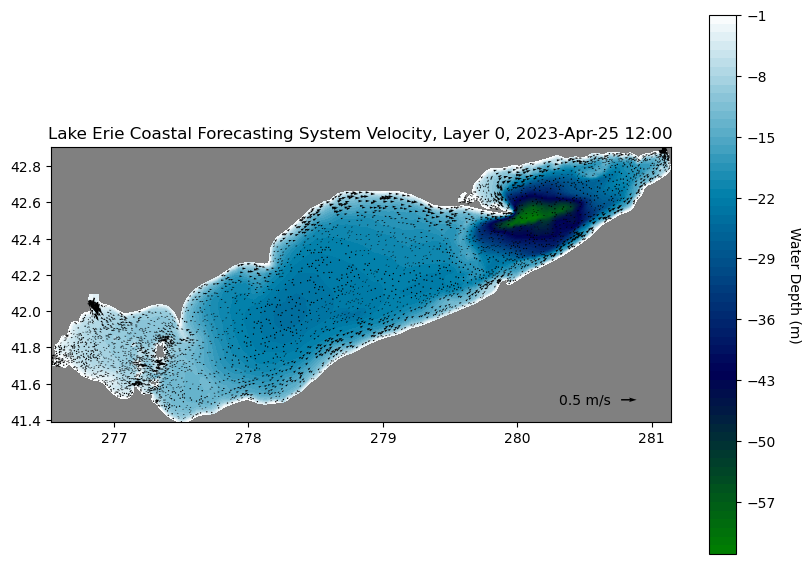

In [18]:
# tricontourf plot of water depth with vectors on top
fig1 = plt.figure(figsize=(10,7))

ax1 = fig1.add_subplot(aspect=(1.0/np.cos(np.mean(lat)*np.pi/180.0)))

# Water depth
plt.tricontourf(tri, -h, levels=levels, cmap=plt.cm.ocean)
plt.axis(ax)

ax1.patch.set_facecolor('0.5')
cbar=plt.colorbar()
cbar.set_label('Water Depth (m)', rotation=-90, labelpad=18)

# Quiver plot
Q = ax1.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=20)
qk = plt.quiverkey(Q,0.92,0.08,0.50,'0.5 m/s',labelpos='W')

plt.title('Lake Erie Coastal Forecasting System Velocity, Layer %d, %s' % (ilayer, daystr))
plt.show()

## Extract Temperature Profile

In [20]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Cleveland OH,   41.72883, -81.798497
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')
# Convert longitude coordinate
obs['Lon'] %= 360 
print(obs)

                   Lat         Lon
Station                           
Cleveland OH  41.72883  278.201503


In [23]:
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    proj = pyproj.Proj('+proj=aea +lat_1=42.122774 +lat_2=49.01518 +lat_0=45.568977 \
    +lon_0=-84.455955 +x_0=1000000 +y_0=1000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')
    
    x, y = proj(x,y)
    xi, yi = proj(np.array(xi),np.array(yi))
    ind=np.ones(len(xi),dtype=int)
    
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
    return ind

# Query to find closest nodes to station locations
obs['NODE-ID'] = nearxy(lon,lat,obs['Lon'],obs['Lat'])
print(obs)

                   Lat         Lon  NODE-ID
Station                                    
Cleveland OH  41.72883  278.201503     2736


In [24]:
# In case you do not have access to the module pyproj, please
# use the code below to find the nearest point.

# Find the indices of the points in (x,y) closest to the points in (xi,yi)
# def nearxy(x,y,xi,yi):
    
#     ind=np.ones(len(xi),dtype=int)
#     for i in np.arange(len(xi)):
#         dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
#         ind[i]=dist.argmin()
        
#     return ind

# # Query to find closest nodes to station locations
# obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
# print(obs)

In [25]:
# Get temperature profile from location named above
# At the time defined above
time.sleep(opendap_pause)
depths = nc.variables['siglay'][:,obs['NODE-ID']] * \
         (nc.variables['h'][obs['NODE-ID']] + \
         nc.variables['zeta'][itime,obs['NODE-ID']])

time.sleep(opendap_pause)
z = nc['temp'][itime,:,obs['NODE-ID']]

In [26]:
# Make a DataFrame out of the interpolated time series for the first station

# Index of station of plot (0 for first station in list, 1 for second station, etc)
station_index = 0

zvals=pd.DataFrame(z[:,station_index],index=depths[:,station_index]) #!!! Modified to use station index rather than assuming only one station is in the list
zvals.index.name = 'depth_m'
zvals.columns=['temp_C']

# Print all values
print(zvals)

              temp_C
depth_m             
-0.557662   5.159328
-1.672987   5.161613
-2.788311   5.164443
-3.903636   5.166065
-5.018961   5.167389
-6.134285   5.168580
-7.249609   5.169696
-8.364934   5.170768
-9.480259   5.171810
-10.595584  5.172830
-11.710909  5.173833
-12.826232  5.174823
-13.941559  5.175801
-15.056882  5.176772
-16.172207  5.177736
-17.287533  5.178701
-18.402855  5.179675
-19.518179  5.180674
-20.633505  5.181738
-21.748831  5.183059


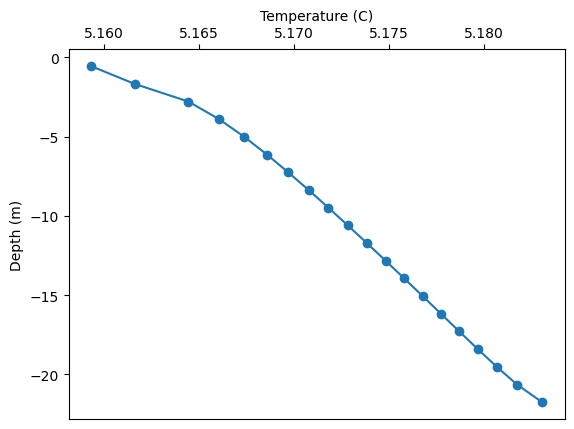

In [27]:
# Plot temperature profile

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(zvals['temp_C'],zvals.index,'o-')

# Draw x label
ax1.set_xlabel('Temperature (C)')
ax1.xaxis.set_label_position('top') # this moves the label to the top
ax1.xaxis.set_ticks_position('top') # this moves the ticks to the top

# Draw y label
ax1.set_ylabel('Depth (m)')

plt.show()

## Extract Current Profile

In [28]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Cleveland OH,   41.72883, -81.798497
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')

# Convert longitude coordinate
obs['Lon'] %= 360
print(obs)

                   Lat         Lon
Station                           
Cleveland OH  41.72883  278.201503


In [29]:
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    proj = pyproj.Proj('+proj=aea +lat_1=42.122774 +lat_2=49.01518 +lat_0=45.568977 \
    +lon_0=-84.455955 +x_0=1000000 +y_0=1000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs') 
    
    x, y = proj(x,y)
    xi, yi = proj(np.array(xi),np.array(yi))
    ind=np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
    return ind

# Query to find closest nodes and elements to station locations
time.sleep(opendap_pause)
obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])

time.sleep(opendap_pause)
obs['ELEM-ID'] = nearxy(nc['lonc'][:],nc['latc'][:],obs['Lon'],obs['Lat'])

print(obs)

                   Lat         Lon  NODE-ID  ELEM-ID
Station                                             
Cleveland OH  41.72883  278.201503     2736     5194


In [30]:
# In case you do not have access to the module pyproj, please
# use the code below to find the nearest point.

# Find the indices of the points in (x,y) closest to the points in (xi,yi)
# def nearxy(x,y,xi,yi):
    
#     ind=np.ones(len(xi),dtype=int)
#     for i in np.arange(len(xi)):
#         dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
#         ind[i]=dist.argmin()
        
#     return ind

# # Query to find closest nodes and elements to station locations
# obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
# obs['ELEM-ID'] = nearxy(nc['lonc'][:],nc['latc'][:],obs['Lon'],obs['Lat'])
# print(obs)

In [31]:
# Get u and v values profile from location named above
time.sleep(opendap_pause)
ui = nc['u'][itime,:,obs['ELEM-ID']]

time.sleep(opendap_pause)
vi = nc['v'][itime,:,obs['ELEM-ID']]

In [32]:
# Get depths nearest observation points
time.sleep(opendap_pause)
depths=nc.variables['siglay'][:,obs['NODE-ID']] * \
        (nc.variables['h'][obs['NODE-ID']] + \
         nc.variables['zeta'][itime,obs['NODE-ID']])    

In [33]:
# Make a DataFrame out of the interpolated time series at the first location
# Index of station of use (0 for first station in list, 1 for second station, etc)
station_index = 0 

uvals=pd.DataFrame(ui[:,station_index],index=depths[:,station_index])
uvals.index.name = 'depth_m'
uvals.columns=['u']

vvals=pd.DataFrame(vi[:,station_index],index=depths[:,station_index])
vvals.index.name = 'depth_m'
vvals.columns=['v']

circ_profile = pd.concat([uvals, vvals], axis=1)

#Print all values
print(circ_profile)

                   u         v
depth_m                       
-0.557662   0.040028  0.026247
-1.672987   0.032888  0.015822
-2.788311   0.023069  0.004561
-3.903636   0.017605 -0.000708
-5.018961   0.013354 -0.004218
-6.134285   0.009766 -0.006768
-7.249609   0.006628 -0.008686
-8.364934   0.003832 -0.010146
-9.480259   0.001310 -0.011257
-10.595584 -0.000983 -0.012094
-11.710909 -0.003077 -0.012709
-12.826232 -0.004998 -0.013142
-13.941559 -0.006762 -0.013422
-15.056882 -0.008385 -0.013573
-16.172207 -0.009877 -0.013611
-17.287533 -0.011247 -0.013546
-18.402855 -0.012497 -0.013380
-19.518179 -0.013619 -0.013095
-20.633505 -0.014563 -0.012610
-21.748831 -0.014914 -0.011373


In [ ]:
nc.close()